# Github Bug Prediction with Sagemaker

The main objective of this project is to apply Deep Learning NLP based techniques to predict the bugs, features, and questions based on GitHub titles and the text body.

We need to predict

    ● Bug - 0
    ● Feature - 1
    ● Question - 2
given Github titles and text.

First install sagemaker, kaggle and transformers

In [1]:
!pip install sagemaker==1.72.0
!pip install kaggle
!pip install transformers -U

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


Import libraries which will be required in our project.

In [2]:
import os
import json
import zipfile
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from tqdm.autonotebook import tqdm
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings('ignore')

# Import sagemaker related libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

First create directory named kaggle which will have json file.

In [3]:
%mkdir .kaggle
!touch .kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


Create kaggle.json file which will have api key to download the dataset

In [4]:
api_token = {"username":"codewarrior0","key":"c01b65090e3a59a881fd19675d7a54e1"}

with open('/home/ec2-user/SageMaker/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/ec2-user/SageMaker/.kaggle/kaggle.json
%mv .kaggle /home/ec2-user

mv: inter-device move failed: ‘.kaggle’ to ‘/home/ec2-user/.kaggle’; unable to remove target: Directory not empty


# Download data from Kaggle

First create data directory named kaggle which will have all the data downloaded from kaggle

In [5]:
%mkdir kaggle

Now download data from Kaggle

In [6]:
!kaggle datasets download -d anmolkumar/github-bugs-prediction

 94%|███████████████████████████████████▌  | 92.0M/98.3M [00:01<00:00, 92.0MB/s]
100%|██████████████████████████████████████| 98.3M/98.3M [00:01<00:00, 92.4MB/s]


Unzip the dataset

In [7]:
!unzip github-bugs-prediction.zip

Archive:  github-bugs-prediction.zip
  inflating: embold_test.json        
  inflating: embold_train.json       
  inflating: embold_train_extra.json  
  inflating: sample submission.csv   


Move train and test data to data folder

In [8]:
%mv embold_train.json kaggle/train.json
%mv embold_test.json kaggle/test.json
%mv embold_train_extra.json kaggle/train_extra.json
%rm github-bugs-prediction.zip
%rm sample\ submission.csv

# Load the dataset

Load training data in a dataframe and see the data

In [9]:
train_df= pd.read_json("./kaggle/train.json").reset_index(drop=True)
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


Load test data in dataframe and see the data

In [10]:
test_df= pd.read_json("./kaggle/test.json").reset_index(drop=True)
test_df.head()

,title,body
0,config question path-specific environment var...,issue description or question\r \r hey @artemg...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,"sarkasmo starting today, when i hit enter act..."
3,not all whitelists are processed,create following rules... order of creation is...
4,add ctx menu for idafree 70 and idafree 5,"associated with .dll, .dll_, .exe, .exe_, .sc,..."


Load extra training data in dataframe and see the data

In [11]:
train_extra_df= pd.read_json("./kaggle/train_extra.json").reset_index(drop=True)
train_extra_df.head()

,title,body,label
0,use a 8bit typeface,since this is meant to emulate some old arcade...,1
1,implement wireless m-bus binding,_from chris.pa...@googlemail.com https://cod...,1
2,add multilang support for timeago.js,currently it is only en . \r required to add ...,1
3,scaleway - seg-fault on shutdown,tbr irc creates a new scaleway instance with...,0
4,sistema de pintura: no se guardar los nuevos p...,este sp ya estaba asignado a un carro y se enc...,0


The data in train.json and train_extra.json is similar. Combine the data in both files as training data.

In [12]:
def dataset_length_check(data_frame):
    print(len(data_frame),data_frame.index.shape[-1])
                 
dataset_length_check(train_df)
dataset_length_check(train_extra_df)
dataset_length_check(test_df)

150000 150000
300000 300000
30000 30000


In [13]:
training_data_frame = train_df[:10000]
training_data_frame.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


Check the combiled length of training data. It should be 450000

In [14]:
training_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10000 non-null  object
 1   body    10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


Now lets categorize the data based on labels and name them as df_bug, df_feature and df_question

Total Counts of label column: 
 1    4550
0    4498
2     952
Name: label, dtype: int64


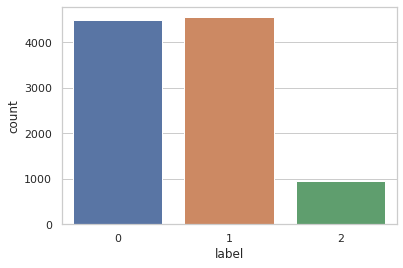

In [15]:
print('Total Counts of label column: \n'.format(),training_data_frame['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=training_data_frame)

In [16]:
df_bug = training_data_frame[training_data_frame['label']==0]
df_feature = training_data_frame[training_data_frame['label']==1]
df_question = training_data_frame[training_data_frame['label']==2]

In [17]:
label_counts = training_data_frame.label.value_counts().sort_index()
label_counts

0    4498
1    4550
2     952
Name: label, dtype: int64

Now we will combine the text in title and body and create new column with name text

In [18]:
def combine(x):
    return x['title'] + " " + x['body']   
training_data_frame['text']= training_data_frame.apply(lambda row : combine(row),axis=1)

In [19]:
print('Number of datapoints with label as Bug :',label_counts[0])
print('Number of datapoints with label as Feature :',label_counts[1])
print('Number of datapoints with label as Question :',label_counts[2])

Number of datapoints with label as Bug : 4498
Number of datapoints with label as Feature : 4550
Number of datapoints with label as Question : 952


In [20]:
training_data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll a y-zoom on the piano roll w...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection ! screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature hi,\r \r great job so far,..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...


# Preprocessing/Cleaning the data

Let's ensure we make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers.

In [21]:
import nltk
import re
import string


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

**Removing Stopwords & Punctuations**

In [22]:
from string import punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(git_text):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    # remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    # remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in git_text.split() if word.lower() not in stopwords.words('english')]
    return filtered_git_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Visualize the Dataset**

In [23]:
from collections import Counter
import plotly.express as px

def visulize_dataset(data_frame, category):
    
    # Let's apply the above two functions 'clean_text' and 'remove_stopwords' to the whole dataset

    data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
    data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
    data_frame["text"] = data_frame["text"].apply(remove_stopwords)
    
    
    word_list = []
    
    for i, j in data_frame.iterrows():
        for word in j['text']:
            word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used while refering to a GitHub {}'.format(category),
                       color_discrete_sequence=['#843B62'] )
    fig.show()

**Printing the text field after Cleaning**

In [24]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
training_data_frame['text'] = training_data_frame['text'].apply(lambda x: x.replace("\\r", ""))
training_data_frame['text'] = training_data_frame['text'].apply(lambda x: clean_text(x))
training_data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


Now remove stopwords and punctuation

In [ ]:
training_data_frame['text'] = training_data_frame["text"].apply(remove_stopwords)
training_data_frame.head()

In [25]:
training_data_frame.describe

<bound method NDFrame.describe of                                                   title  \
0                                     y-zoom piano roll   
1                           buggy behavior in selection   
2                                   auto update feature   
3                    filter out noisy endpoints in logs   
4     enable pid on / pid off alarm actions for ardu...   
...                                                 ...   
9995  planned event bug: \ page not found\  as regul...   
9996                                idea: tour recorder   
9997        extract  add support for parsing jats files   
9998  volume store folder name validation in the cre...   
9999                                    building on osx   

                                                   body  label  \
0           a y-zoom on the piano roll would be useful.      1   
1     ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2     hi,\r \r great job so far, @saenzramiro ! : \r...    

Now create a directory name data which will hold the processed data

In [26]:
%mkdir data

We only need the text and label column from our data for training. Extract text and label column from data_frame and write it in data directory

In [27]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(training_data_frame[['label', 'text']])
train.to_csv("./data/train.csv", index = False)
validation.to_csv("./data/validation.csv", index = False)

Repeat same steps for testing data. Clean and preprocess it and write the data in test.csv file in data directory

In [28]:
# Combining title and body and creating new column with name text
test_df['text'] = test_df.apply(lambda row : combine(row),axis=1)
# Clean the text column by removing punctuation, stopwords etc
test_df['text'] = test_df['text'].apply(lambda x: x.replace("\\r", ""))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))
#test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(x))
test_df.head()
# Extract text and label column
test = test_df[['text']]
test.to_csv("./data/test.csv", index = False)

In [29]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Upload data to S3

Get sagemaker session, s3 bucket to upload data

In [30]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'mlcapstone/bug_prediction'
role = sagemaker.get_execution_role()

Upload the data to S3

In [31]:
input_train = sagemaker_session.upload_data("./data/train.csv", bucket=bucket, key_prefix=prefix)
input_validation = sagemaker_session.upload_data("./data/validation.csv", bucket=bucket, key_prefix=prefix)
input_test = sagemaker_session.upload_data("./data/test.csv", bucket=bucket, key_prefix=prefix)

# Creating Model on Sagemaker

In [32]:
from sagemaker.pytorch import PyTorch

# place to save model artifact
output_path = "s3://{}/{}".format(bucket, prefix)

estimator = PyTorch(
    entry_point="train_deploy.py",
    source_dir="train",
    role=role,
    framework_version="1.3.1",
    py_version="py3",
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
    output_path=output_path,
    hyperparameters={
        "epochs": 1,
        "num_labels": 3,
        "batch_size": 8,
        "test_batch_size": 8
    }
)
estimator.fit({"training": input_train, "testing": input_validation})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-03-01 15:35:48 Starting - Starting the training job...
2021-03-01 15:35:50 Starting - Launching requested ML instances......
2021-03-01 15:37:05 Starting - Preparing the instances for training......
2021-03-01 15:38:18 Downloading - Downloading input data...
2021-03-01 15:38:38 Training - Downloading the training image.....................
2021-03-01 15:42:17 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-01 15:42:19,416 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-01 15:42:19,445 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-01 15:42:20,879 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-01 15:42:21,263 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating set

Deploy our endpoint, we call deploy() on our PyTorch estimator object, passing in our desired number of instances and instance type:

In [33]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

Configure the predictor to use application/json

In [34]:
predictor.serializer = sagemaker.predictor._JsonSerializer
predictor.deserializer = sagemaker.predictor._JsonDeserializer

In [54]:
training_data_frame['text'][0]

'yzoom piano roll a yzoom on the piano roll would be useful'

Test with sample data

In [58]:
result = predictor.predict(training_data_frame['text'][0])
#print("predicted class: ", np.argmax(result, axis=1))

TypeError: __init__() takes 1 positional argument but 2 were given

# Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.